# Determining Sigma 10 & R 10 of DESIJ0201-2739

**Author(s)**: S M Rafee Adnan, Sulyman Hossain, Anowar Shajib <br>
**Acknowledgement(s)**: Ahmad Al - Imtiaz, Mamunur Rashid

## Load data

In [1]:
!pip install pandas
!pip install yaml
!pip install astropy
!pip install photutils

ERROR: Could not find a version that satisfies the requirement yaml (from versions: none)
ERROR: No matching distribution found for yaml
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.8 MB/s eta 0:00:00


In [2]:
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy.stats import SigmaClip
from astropy.visualization import simple_norm
from astropy.wcs import WCS
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import (
    SourceCatalog,
    SourceFinder,
    deblend_sources,
    detect_sources,
)

In [3]:
data, header = fits.getdata(
    "/kaggle/input/fits-file/DESIJ0201-2739_F140W_drz_sci.fits", header=True
)

<ipython-input-4-23c0fe87f6d7>:1: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(data), origin="lower", cmap="cubehelix", interpolation="nearest")


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


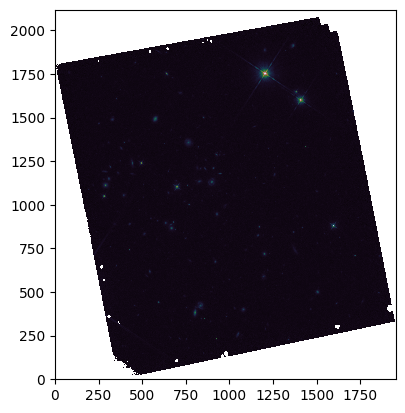

In [4]:
plt.imshow(np.log10(data), origin="lower", cmap="cubehelix", interpolation="nearest")

## Background estimation

In [5]:
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()
bkg = Background2D(
    data,
    (50, 50),
    filter_size=(3, 3),
    sigma_clip=sigma_clip,
    bkg_estimator=bkg_estimator,
)

<ipython-input-6-eab7ae52f2d2>:2: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


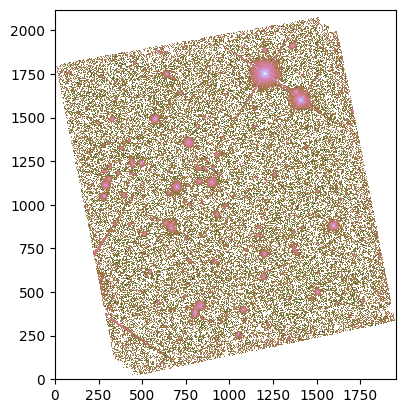

In [6]:
plt.imshow(
    np.log10(data - bkg.background),
    origin="lower",
    cmap="cubehelix",
    interpolation="nearest",
)

## Aperture photometry

In [7]:
np.median(bkg.background), np.median(bkg.background_rms)

(0.33989102, 0.0140189575)

In [8]:
bkg_subtracted_data = data - bkg.background

In [9]:
threshold = 3 * bkg.background_rms

In [10]:
segment_map = detect_sources(bkg_subtracted_data, threshold, npixels=10)

In [11]:
segm_deblend = deblend_sources(
    bkg_subtracted_data,
    segment_map,
    npixels=10,
    nlevels=32,
    contrast=0.001,
    progress_bar=False,
)

In [12]:
finder = SourceFinder(npixels=10, progress_bar=False)
segment_map = finder(bkg_subtracted_data, threshold)

print(segment_map)

<photutils.segmentation.core.SegmentationImage>
shape: (2119, 1955)
nlabels: 692
labels: [  1   2   3   4   5 ... 688 689 690 691 692]


In [13]:
cat = SourceCatalog(bkg_subtracted_data, segm_deblend)
print(cat)
print(type(cat))

<photutils.segmentation.catalog.SourceCatalog>
Length: 692
labels: [  1   2   3   4   5 ... 688 689 690 691 692]
<class 'photutils.segmentation.catalog.SourceCatalog'>


## Adjust the region near your lensing system

In [14]:
set_x_lim1, set_x_lim2 = 700, 1100
set_y_lim1, set_y_lim2 = 950, 1350

<ipython-input-15-36ad019788fe>:5: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/usr/local/lib/python3.10/dist-packages/photutils/segmentation/catalog.py:879: RuntimeWarning: invalid value encountered in less
  | (convdata_cutout < 0) | segmmask_cutout)
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


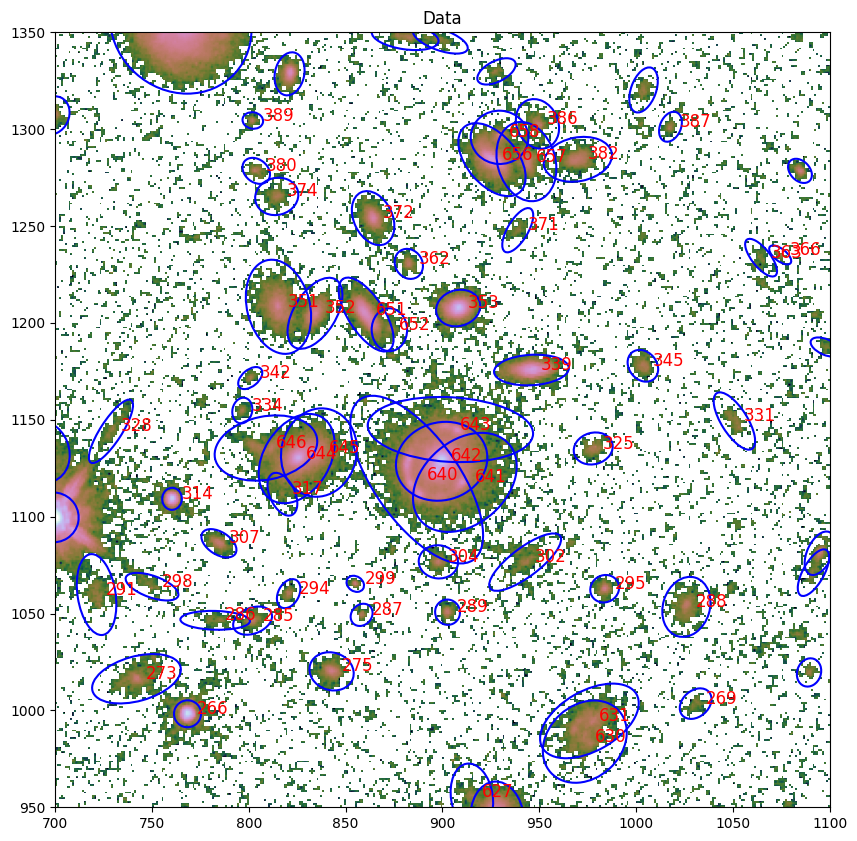

In [15]:
norm = simple_norm(data, "sqrt")

fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

cat.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)

# Before determining the central ID
# for i in range(len(cat)):
#     ax1.text(
#         cat.xcentroid[i] + 5,
#         cat.ycentroid[i],
#         f"{i}",
#         c="r",
#         fontsize=12
#     )

# After determining the central ID
id_central = 642
for i in range(len(cat)):
    if (
        np.abs(cat.xcentroid[i] - cat.xcentroid[id_central]) < 180
        and np.abs(cat.ycentroid[i] - cat.ycentroid[id_central]) < 180
    ):
        ax1.text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

ax1.set_xlim(set_x_lim1, set_x_lim2)
ax1.set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

## Determine the central deflector's ID

<ipython-input-16-0ee8635282d2>:8: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


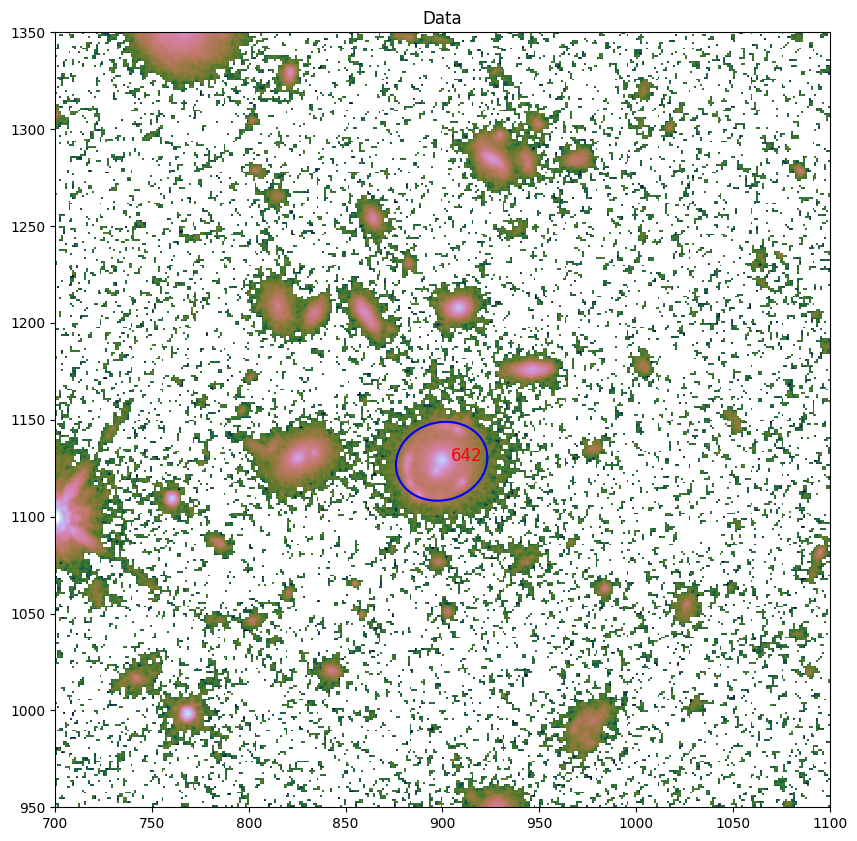

In [16]:
# object id of your central deflector/lens
id_central = 642

norm = simple_norm(data, "sqrt")

fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

labels_1 = [id_central + 1]
cat_subset_1 = cat.get_labels(labels_1)

cat_subset_1.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)

ax1.text(
    cat.xcentroid[id_central] + 5,
    cat.ycentroid[id_central],
    f"{id_central}",
    c="r",
    fontsize=12,
)

ax1.set_xlim(set_x_lim1, set_x_lim2)
ax1.set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

In [17]:
tbl = cat.to_table()
tbl["xcentroid"].info.format = ".2f"  # optional format
tbl["ycentroid"].info.format = ".2f"
tbl["kron_flux"].info.format = ".2f"

## Creating List of neighbouring Galaxies

In [18]:
# All close galaxies

x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_all = []
dist_galaxies_all = []
flux_galaxies_all = []
axis_ratios_all = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if (
        np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 20 / 0.08
    ):  # Find neighbouring galaxies within 20 arcseconds
        close_galaxies_all.append(i)
        flux_galaxies_all.append(f)
        dist_galaxies_all.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_all.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))

print(
    "Number of all close galaxies within 20 arcsecond radius:", len(close_galaxies_all)
)

Number of all close galaxies within 20 arcsecond radius: 74


In [19]:
# close galaxies excluding sources lower than 1% of the central deflector

x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_1 = []
dist_galaxies_1 = []
flux_galaxies_1 = []
axis_ratios_1 = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if (np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 20 / 0.08) & (f > f0 * 0.01):
        close_galaxies_1.append(i)
        flux_galaxies_1.append(f)
        dist_galaxies_1.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_1.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))
print(
    "Number of close galaxies excluding dim sources within 20 arcsecond radius:",
    len(close_galaxies_1),
)

Number of close galaxies excluding dim sources within 20 arcsecond radius: 51


In [20]:
def distance_parsec(pixel_distance, z):
    """Convert distance from unit of pixels into parsec unit.

    :param pixel_distance: distance in unit of pixels

    :param z: photometric redshift

    :return: distance in parsec unit

    """

    wcs = WCS(header)

    # Get the pixel scale in degrees per pixel
    pix_scale_deg = abs(wcs.wcs.cd[0, 0])

    # Convert the pixel scale from degrees to radians
    pix_scale_radian = pix_scale_deg * np.pi / 180

    # Angles in radians
    angles_radian = pixel_distance * pix_scale_radian

    # Define cosmological parameters
    H0 = 70  # Hubble constant in km/s/Mpc
    Om0 = 0.3  # Matter density parameter
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)

    # Compute the angular diameter distance
    angular_diameter_distance = cosmo.angular_diameter_distance(z)

    # Calculate the physical distance
    physical_distances_mpc = angular_diameter_distance * angles_radian

    return physical_distances_mpc

In [21]:
# list of galaxies you want removed
remove_list = [
    642,  # This is the central deflector
    640,  # Object is part of the lensed arc
    643,  # Object is part of the lensed arc
    641,  # Object is part of the lensed arc
    317,  # Halo of object ID 644
    644,  # high redshift (legacy id: 5330)
    339,  # high redshift (legacy id: 5325)
    353,  # high redshift (legacy id: 5327)
    651,  # high redshift (legacy id: 5329)
    314,  # high redshift (legacy id: 5326)
    631,  # high redshift (legacy id: 5292)
    656,  # high redshift (legacy id: 5328)
]

df_all = pd.DataFrame({"Distance(pixels)": dist_galaxies_all})

df_all.set_index(pd.Index(close_galaxies_all), inplace=True)

# Photometric redshift of the deflector galaxy is 0.747
df_all["Distance(megaparsec)"] = distance_parsec(df_all["Distance(pixels)"], 0.747)
df_all["Flux"] = flux_galaxies_all
df_all["Axis Ratio"] = axis_ratios_all

# Sort the DataFrame based on 'Distance'
df_all_sorted = df_all.sort_values(by="Distance(pixels)")

# Exclude unwanted sources
df_all_sys_removed = df_all_sorted.drop(remove_list)

# first 20 galaxies
df_all_20 = df_all_sys_removed.iloc[:20]

print(df_all_20)

     Distance(pixels)  Distance(megaparsec)       Flux  Axis Ratio
304         51.939759              0.030446   6.190484    0.842565
645         63.472978              0.037206  63.328373    0.846906
302         67.588391              0.039619   8.122346    0.328468
652         73.061613              0.042827   4.841572    0.825998
299         77.382892              0.045360   1.952441    0.798560
289         77.954364              0.045695   4.347336    0.971245
325         78.519001              0.046026   6.153290    0.793196
287         89.379494              0.052392   1.896048    0.838999
646         90.930448              0.053301  24.829413    0.607415
352        100.534058              0.058931  30.979141    0.531990
362        103.280742              0.060541   4.570670    0.864457
294        104.408831              0.061202   2.949858    0.666763
334        106.162500              0.062230   1.890455    0.761348
295        106.802933              0.062606   6.681668    0.91

In [22]:
remove_list_1 = [
    642,  # This is the central deflector
    640,  # Object is part of the lensed arc
    643,  # Object is part of the lensed arc
    641,  # Object is part of the lensed arc
    644,  # high redshift (legacy id: 5330)
    339,  # high redshift (legacy id: 5325)
    353,  # high redshift (legacy id: 5327)
    651,  # high redshift (legacy id: 5329)
    314,  # high redshift (legacy id: 5326)
    631,  # high redshift (legacy id: 5292)
    656,  # high redshift (legacy id: 5328)
]
df_1 = pd.DataFrame({"Distance(pixels)": dist_galaxies_1})

df_1.set_index(pd.Index(close_galaxies_1), inplace=True)

# Photometric redshift of the deflector galaxy is 0.747
df_1["Distance(megaparsec)"] = distance_parsec(df_1["Distance(pixels)"], 0.747)
df_1["Flux"] = flux_galaxies_1
df_1["Axis Ratio"] = axis_ratios_1

# Sort the DataFrame based on 'Distance'
df_1_sorted = df_1.sort_values(by="Distance(pixels)")

# Exclude the lensing system members
df_1_sys_removed = df_1_sorted.drop(remove_list_1)

# first 20 galaxies
df_1_20 = df_1_sys_removed.iloc[:20]

print(df_1_20)

     Distance(pixels)  Distance(megaparsec)       Flux  Axis Ratio
304         51.939759              0.030446   6.190484    0.842565
645         63.472978              0.037206  63.328373    0.846906
302         67.588391              0.039619   8.122346    0.328468
652         73.061613              0.042827   4.841572    0.825998
289         77.954364              0.045695   4.347336    0.971245
325         78.519001              0.046026   6.153290    0.793196
646         90.930448              0.053301  24.829413    0.607415
352        100.534058              0.058931  30.979141    0.531990
362        103.280742              0.060541   4.570670    0.864457
295        106.802933              0.062606   6.681668    0.912629
345        114.970668              0.067393   6.213297    0.799982
351        115.970359              0.067979  52.823807    0.654471
275        122.403060              0.071750  13.620345    0.833262
307        122.493914              0.071803   8.280468    0.57

## Visualizing removed objects (except central deflector)

<ipython-input-23-11fa5be51446>:5: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


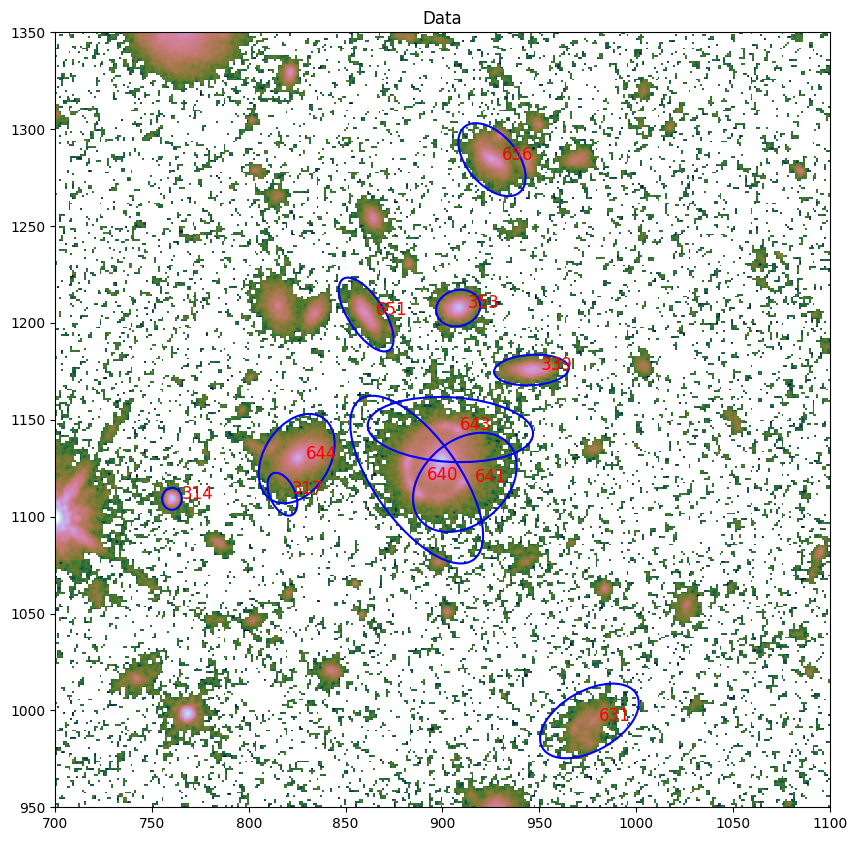

In [23]:
norm = simple_norm(data, "sqrt")

fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

remove_list_exc_central = remove_list
if id_central in remove_list_exc_central:
    remove_list_exc_central.remove(id_central)

updated_remove_list = [s + 1 for s in remove_list_exc_central]
cat_subset_removed = cat.get_labels(updated_remove_list)
cat_subset_removed.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)

for i in remove_list:
    ax1.text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

ax1.set_xlim(set_x_lim1, set_x_lim2)
ax1.set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

## Calculating $\Sigma_{10}$, $\Sigma_{10,\text{flux selected}}$ , $\Sigma_{20}$, $\Sigma_{20,\text{flux selected}}$ and the corresponding radii

<ipython-input-24-653a0a499e84>:17: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
<ipython-input-24-653a0a499e84>:20: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
<ipython-input-24-653a0a499e84>:23: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
<ipython-input-24-653a0a499e84>:26: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


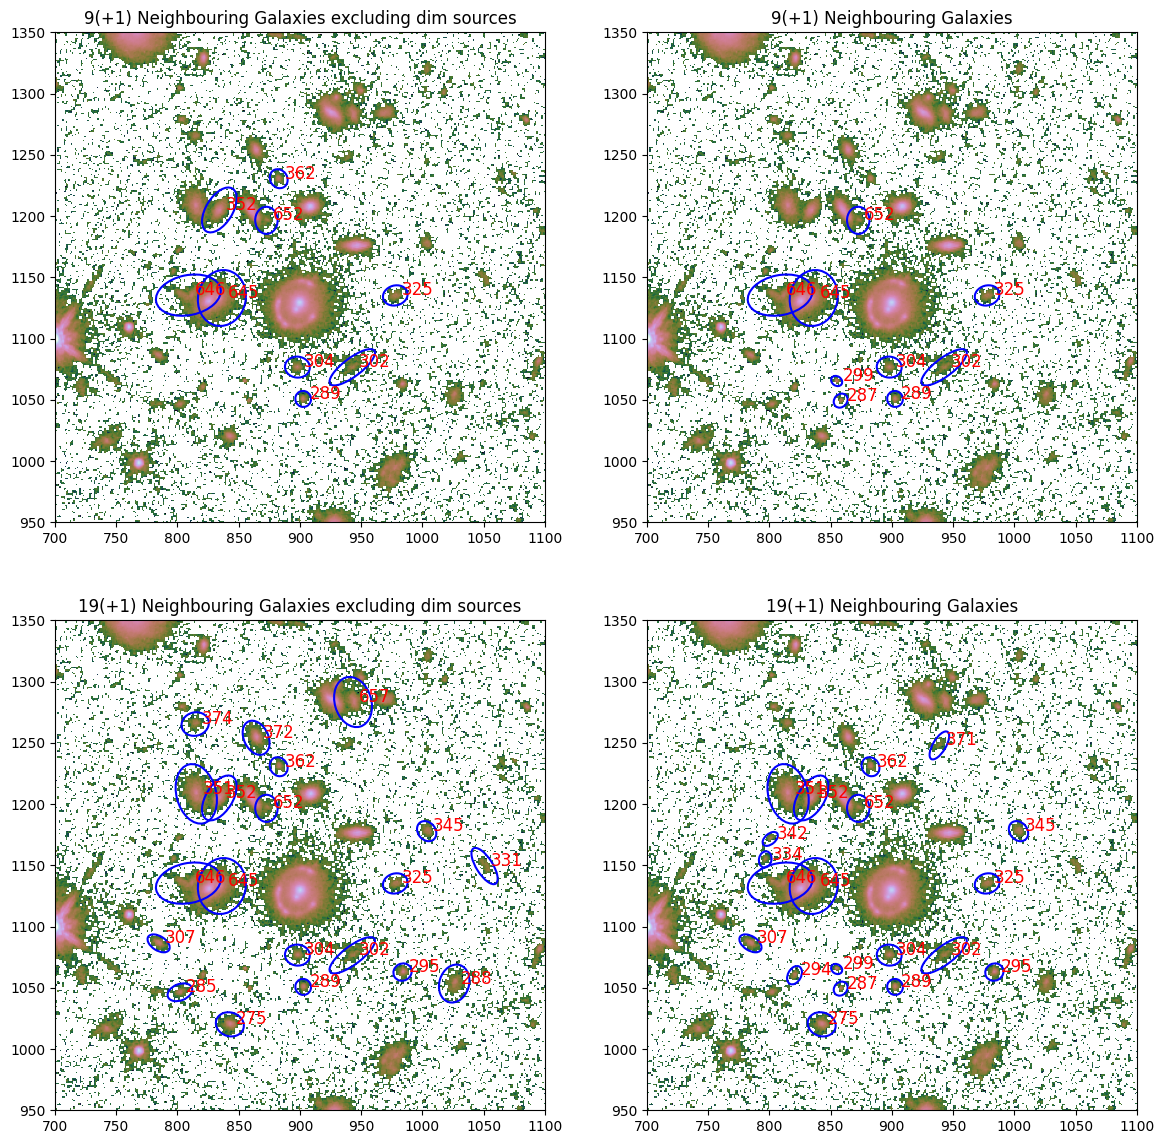

In [24]:
close_ids_all = list(df_all_20.index.values)
close_ids_all_10 = close_ids_all[: 10 - 1]

updated_close_ids_all = [s + 1 for s in close_ids_all]
updated_close_ids_all_10 = updated_close_ids_all[: 10 - 1]

close_ids_1 = list(df_1_20.index.values)
close_ids_1_10 = close_ids_1[: 10 - 1]

updated_close_ids_1 = [s + 1 for s in close_ids_1]
updated_close_ids_1_10 = updated_close_ids_1[: 10 - 1]

norm = simple_norm(data, "sqrt")
fig, axs = plt.subplots(2, 2, figsize=(14, 14))  # , figsize=(10, 12.5)

axs[0, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[0, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1, 1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)

cat_subset_1_10 = cat.get_labels(updated_close_ids_1_10)
cat_subset_1_10.plot_kron_apertures(ax=axs[0, 0], color="blue", lw=1.5)

cat_subset_all_10 = cat.get_labels(updated_close_ids_all_10)
cat_subset_all_10.plot_kron_apertures(ax=axs[0, 1], color="blue", lw=1.5)

cat_subset_all = cat.get_labels(updated_close_ids_1)
cat_subset_all.plot_kron_apertures(ax=axs[1, 0], color="blue", lw=1.5)

cat_subset_1 = cat.get_labels(updated_close_ids_all)
cat_subset_1.plot_kron_apertures(ax=axs[1, 1], color="blue", lw=1.5)

axs[0, 0].set_title("9(+1) Neighbouring Galaxies excluding dim sources")
axs[0, 1].set_title("9(+1) Neighbouring Galaxies")
axs[1, 0].set_title("19(+1) Neighbouring Galaxies excluding dim sources")
axs[1, 1].set_title("19(+1) Neighbouring Galaxies")

for i in close_ids_1_10:
    axs[0, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all_10:
    axs[0, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_1:
    axs[1, 0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all:
    axs[1, 1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

axs[0, 0].set_xlim(set_x_lim1, set_x_lim2)
axs[0, 0].set_ylim(set_y_lim1, set_y_lim2)

axs[0, 1].set_xlim(set_x_lim1, set_x_lim2)
axs[0, 1].set_ylim(set_y_lim1, set_y_lim2)

axs[1, 0].set_xlim(set_x_lim1, set_x_lim2)
axs[1, 0].set_ylim(set_y_lim1, set_y_lim2)

axs[1, 1].set_xlim(set_x_lim1, set_x_lim2)
axs[1, 1].set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
axs[0, 0].set_clip_on(True)
axs[0, 0].set_clip_box(axs[0, 0].bbox)

axs[0, 1].set_clip_on(True)
axs[0, 1].set_clip_box(axs[0, 0].bbox)

axs[1, 0].set_clip_on(True)
axs[1, 0].set_clip_box(axs[0, 0].bbox)

axs[1, 1].set_clip_on(True)
axs[1, 1].set_clip_box(axs[0, 0].bbox)

## Loading Global Mean

In [25]:
# Read flux data from each YAML file and append to corresponding lists
input_path = "/kaggle/input/updated-global-mean/DESIJ0201-2739_means.yml"

try:
    with open(input_path, "r") as f:
        data_mean = yaml.safe_load(f)
except (AttributeError, yaml.YAMLError) as e:
    print(f"Failed to load the file: {e}")

global_mean_flux_10 = data_mean.get("Global_mean_flux_10")
global_mean_flux_20 = data_mean.get("Global_mean_flux_20")
global_mean_flux_selected_10 = data_mean.get("Global_mean_flux_selected_10")
global_mean_flux_selected_20 = data_mean.get("Global_mean_flux_selected_20")
global_mean_flux_dis_10 = data_mean.get("Global_mean_flux_dis_10")
global_mean_flux_dis_20 = data_mean.get("Global_mean_flux_dis_20")
global_mean_flux_dis_selected_10 = data_mean.get("Global_mean_flux_dis_selected_10")
global_mean_flux_dis_selected_20 = data_mean.get("Global_mean_flux_dis_selected_20")

## Generating a distribution of the Physical distance using Monte Carlo random sampling to calculate uncertainty in sigma densities

In [26]:
z = 0.747  # redshift
z_uncertainty = 0.065  # redshift's uncertainty

# Define a function to estimate uncertainty in the Physical distance using
# Monte Carlo random sampling


def calculate_physical_distance_distribution(
    pixel_distance, z, z_uncertainty, num_samples=10000
):
    # Generate random samples of redshift using normal distribution
    z_samples = np.random.normal(z, z_uncertainty, num_samples)

    # Define a function to calculate physical distance
    # from redshift

    def distance_parsec(pixel_distance, z):
        """Convert distance from unit of pixels into parsec unit.

        :param pixel_distance: distance in unit of pixels

        :param z: photometric redshift

        :return: distance in parsec unit

        """

        wcs = WCS(header)

        # Get the pixel scale in degrees per pixel
        pix_scale_deg = abs(wcs.wcs.cd[0, 0])

        # Convert the pixel scale from degrees to radians
        pix_scale_radian = pix_scale_deg * np.pi / 180

        # Angles in radians
        angles_radian = pixel_distance * pix_scale_radian

        # Define cosmological parameters
        H0 = 70  # Hubble constant in km/s/Mpc
        Om0 = 0.3  # Matter density parameter
        cosmo = FlatLambdaCDM(H0=H0, Om0=Om0)

        # Compute the angular diameter distance
        angular_diameter_distance = cosmo.angular_diameter_distance(z)

        # Calculate the physical distance
        physical_distances_mpc = angular_diameter_distance * angles_radian

        return physical_distances_mpc.value

    # Calculate physical distances for each sampled redshift and pixel distance
    physical_distances = distance_parsec(pixel_distance, z_samples)

    return physical_distances

## Method A

In [27]:
# One satellite galaxy (along 6 o'clock) near the lens galaxy was undetected due to
# threshold conditions. To include this object in the calculation, we only take
# the distance of the 9th and 19th closest galaxies to calculate R_10 and R_20,
# for both cases including and excluding dim sources.

# # For all sources
# R_10_all = df_all_20.iloc[
#     8, df_all_20.columns.get_loc("Distance(megaparsec)")
# ]  ## Change
# R_20_all = df_all_20.iloc[
#     18, df_all_20.columns.get_loc("Distance(megaparsec)")
# ]  ## Change
# Sigma_10_allA = 10 / (np.pi * R_10_all**2)
# Sigma_20_allA = 20 / (np.pi * R_20_all**2)

# # Excluding dim sources
# R_10_1 = df_1_20.iloc[8, df_1_20.columns.get_loc("Distance(megaparsec)")]  ## Change
# R_20_1 = df_1_20.iloc[18, df_1_20.columns.get_loc("Distance(megaparsec)")]  ## Change
# Sigma_10_1A = 10 / (np.pi * R_10_1**2)
# Sigma_20_1A = 20 / (np.pi * R_20_1**2)


# print("")
# print("FOR All SOURCES")
# print("R 10:", R_10_all)
# print("R 20:", R_20_all)
# print("Sigma 10:", Sigma_10_allA)
# print("Sigma 20:", Sigma_20_allA)

# print("")
# print("EXCLUDING DIM SOURCES")
# print("R 10:", R_10_1)
# print("R 20:", R_20_1)
# print("Sigma 10:", Sigma_10_1A)
# print("Sigma 20:", Sigma_20_1A)

# For all sources

r_10_all = df_all_20.iloc[8, df_all_20.columns.get_loc("Distance(pixels)")]
R_10_all = calculate_physical_distance_distribution(r_10_all, z, z_uncertainty)

r_20_all = df_all_20.iloc[18, df_all_20.columns.get_loc("Distance(pixels)")]
R_20_all = calculate_physical_distance_distribution(r_20_all, z, z_uncertainty)

Sigma_10_allA_distribution = []
Sigma_20_allA_distribution = []

for i in range(10000):
    Sigma_10_allA = 10 / (np.pi * R_10_all[i] ** 2)
    Sigma_20_allA = 20 / (np.pi * R_20_all[i] ** 2)

    Sigma_10_allA_distribution.append(Sigma_10_allA)
    Sigma_20_allA_distribution.append(Sigma_20_allA)

Sigma_10_allA_mean = np.mean(Sigma_10_allA_distribution)
Sigma_10_allA_std = np.std(Sigma_10_allA_distribution)
Sigma_20_allA_mean = np.mean(Sigma_20_allA_distribution)
Sigma_20_allA_std = np.std(Sigma_20_allA_distribution)

# Excluding dim sources

r_10_1 = df_1_20.iloc[8, df_1_20.columns.get_loc("Distance(pixels)")]
R_10_1 = calculate_physical_distance_distribution(r_10_1, z, z_uncertainty)

r_20_1 = df_1_20.iloc[18, df_1_20.columns.get_loc("Distance(pixels)")]
R_20_1 = calculate_physical_distance_distribution(r_20_1, z, z_uncertainty)

Sigma_10_1A_distribution = []
Sigma_20_1A_distribution = []

for i in range(10000):
    Sigma_10_1A = 10 / (np.pi * R_10_1[i] ** 2)
    Sigma_20_1A = 20 / (np.pi * R_20_1[i] ** 2)

    Sigma_10_1A_distribution.append(Sigma_10_1A)
    Sigma_20_1A_distribution.append(Sigma_20_1A)

Sigma_10_1A_mean = np.mean(Sigma_10_1A_distribution)
Sigma_10_1A_std = np.std(Sigma_10_1A_distribution)
Sigma_20_1A_mean = np.mean(Sigma_20_1A_distribution)
Sigma_20_1A_std = np.std(Sigma_20_1A_distribution)

print("")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10:", Sigma_10_allA_mean, "Std:", Sigma_10_allA_std)
print("Sigma 20:", Sigma_20_allA_mean, "Std:", Sigma_20_allA_std)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10:", Sigma_10_1A_mean, "Std:", Sigma_10_1A_std)
print("Sigma 20:", Sigma_20_1A_mean, "Std:", Sigma_20_1A_std)


FOR All SOURCES
R 10: [0.05184869 0.05168874 0.05397346 ... 0.05375697 0.05409304 0.05416805]
R 20: [0.07401242 0.07309259 0.07053363 ... 0.06942593 0.07437496 0.07322454]
Sigma 10: 1130.197339136597 Std: 76.03578046461638
Sigma 20: 1247.4183737838111 Std: 85.18583298326904

EXCLUDING DIM SOURCES
R 10: [0.05931544 0.06148282 0.05844862 ... 0.05959955 0.06048671 0.06123453]
R 20: [0.09118832 0.09570429 0.09579584 ... 0.09888163 0.09477497 0.09521129]
Sigma 10: 875.4013244815756 Std: 58.799845038924786
Sigma 20: 722.9263600004579 Std: 48.850917081617176


## Method B

In [28]:
# # light flux of the undetected satellite galaxy is 80.49
# # and distance from the central deflector is 0.5 pixels

# weighted_flux_10_all = (np.sum(df_all_20["Flux"][0:9]) + 80.49) / global_mean_flux_10
# weighted_flux_20_all = (np.sum(df_all_20["Flux"][0:19]) + 80.49) / global_mean_flux_20
# Sigma_10_allB = weighted_flux_10_all / (np.pi * R_10_all**2)
# Sigma_20_allB = weighted_flux_20_all / (np.pi * R_20_all**2)


# weighted_flux_10_1 = (
#     np.sum(df_1_20["Flux"][0:9]) + 80.49
# ) / global_mean_flux_selected_10
# weighted_flux_20_1 = (
#     np.sum(df_1_20["Flux"][0:19]) + 80.49
# ) / global_mean_flux_selected_20
# Sigma_10_1B = weighted_flux_10_1 / (np.pi * R_10_1**2)
# Sigma_20_1B = weighted_flux_20_1 / (np.pi * R_20_1**2)


# print("")
# print("Considering Light Flux")
# print("FOR All SOURCES")
# print("R 10:", R_10_all)
# print("R 20:", R_20_all)
# print("Sigma 10_updated:", Sigma_10_allB)
# print("Sigma 20_updated:", Sigma_20_allB)

# print("")
# print("EXCLUDING DIM SOURCES")
# print("R 10:", R_10_1)
# print("R 20:", R_20_1)
# print("Sigma 10_updated:", Sigma_10_1B)
# print("Sigma 20_updated:", Sigma_20_1B)

# For all sources
weighted_flux_10_all = (np.sum(df_all_20["Flux"][0:9]) + 80.49) / global_mean_flux_10
weighted_flux_20_all = (np.sum(df_all_20["Flux"][0:19]) + 80.49) / global_mean_flux_20

Sigma_10_allB_distribution = []
Sigma_20_allB_distribution = []

for i in range(10000):
    Sigma_10_allB = weighted_flux_10_all / (np.pi * R_10_all[i] ** 2)
    Sigma_20_allB = weighted_flux_20_all / (np.pi * R_20_all[i] ** 2)

    Sigma_10_allB_distribution.append(Sigma_10_allB)
    Sigma_20_allB_distribution.append(Sigma_20_allB)

Sigma_10_allB_mean = np.mean(Sigma_10_allB_distribution)
Sigma_10_allB_std = np.std(Sigma_10_allB_distribution)
Sigma_20_allB_mean = np.mean(Sigma_20_allB_distribution)
Sigma_20_allB_std = np.std(Sigma_20_allB_distribution)

# excluding dim sources
weighted_flux_10_1 = (
    np.sum(df_1_20["Flux"][0:9]) + 80.49
) / global_mean_flux_selected_10
weighted_flux_20_1 = (
    np.sum(df_1_20["Flux"][0:19]) + 80.49
) / global_mean_flux_selected_20

Sigma_10_1B_distribution = []
Sigma_20_1B_distribution = []

for i in range(10000):
    Sigma_10_1B = weighted_flux_10_1 / (np.pi * R_10_1[i] ** 2)
    Sigma_20_1B = weighted_flux_20_1 / (np.pi * R_20_1[i] ** 2)

    Sigma_10_1B_distribution.append(Sigma_10_1B)
    Sigma_20_1B_distribution.append(Sigma_20_1B)

Sigma_10_1B_mean = np.mean(Sigma_10_1B_distribution)
Sigma_10_1B_std = np.std(Sigma_10_1B_distribution)
Sigma_20_1B_mean = np.mean(Sigma_20_1B_distribution)
Sigma_20_1B_std = np.std(Sigma_20_1B_distribution)


print("")
print("Considering Light Flux")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10_updated:", Sigma_10_allB_mean, "Std:", Sigma_10_allB_std)
print("Sigma 20_updated:", Sigma_20_allB_mean, "Std:", Sigma_20_allB_std)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10_updated:", Sigma_10_1B_mean, "Std:", Sigma_10_1B_std)
print("Sigma 20_updated:", Sigma_20_1B_mean, "Std:", Sigma_20_1B_std)


Considering Light Flux
FOR All SOURCES
R 10: [0.05184869 0.05168874 0.05397346 ... 0.05375697 0.05409304 0.05416805]
R 20: [0.07401242 0.07309259 0.07053363 ... 0.06942593 0.07437496 0.07322454]
Sigma 10_updated: 321.46353248718606 Std: 21.62695817550636
Sigma 20_updated: 315.6617783925509 Std: 21.55644978339063

EXCLUDING DIM SOURCES
R 10: [0.05931544 0.06148282 0.05844862 ... 0.05959955 0.06048671 0.06123453]
R 20: [0.09118832 0.09570429 0.09579584 ... 0.09888163 0.09477497 0.09521129]
Sigma 10_updated: 95.7172047985162 Std: 6.429230402461239
Sigma 20_updated: 80.5136978248614 Std: 5.440620502998664


## Method C

In [29]:
# # light flux of the undetected satellite galaxy is 80.49
# # and distance from the central deflector is 0.5 pixels
# satdis = distance_parsec(0.5, 0.747).value

# # Initialize flux variables
# flux_c_10_all = []
# flux_c_20_all = []
# flux_c_10_1 = []
# flux_c_20_1 = []

# # for all sources
# for i in range(19):
#     flux_all = (
#         df_all_20["Flux"][i : i + 1] / df_all_20["Distance(megaparsec)"][i : i + 1]
#     )

#     if i < 9:
#         flux_c_10_all.append(flux_all)
#         flux_c_20_all.append(flux_all)

#     elif 8 < i < 19:
#         flux_c_20_all.append(flux_all)

# weighted_flux_10_all = (
#     np.sum(flux_c_10_all) + (80.49 / satdis)
# ) / global_mean_flux_dis_10
# weighted_flux_20_all = (
#     np.sum(flux_c_20_all) + (80.49 / satdis)
# ) / global_mean_flux_dis_20
# Sigma_10_allC = weighted_flux_10_all / (np.pi * R_10_all**2)
# Sigma_20_allC = weighted_flux_20_all / (np.pi * R_20_all**2)

# # excluding dim sources
# for i in range(19):
#     flux_1 = df_1_20["Flux"][i : i + 1] / df_1_20["Distance(megaparsec)"][i : i + 1]

#     if i < 9:
#         flux_c_10_1.append(flux_1)
#         flux_c_20_1.append(flux_1)

#     elif 8 < i < 19:
#         flux_c_20_1.append(flux_1)

# weighted_flux_10_1 = (
#     np.sum(flux_c_10_1) + (80.49 / satdis)
# ) / global_mean_flux_dis_selected_10
# weighted_flux_20_1 = (
#     np.sum(flux_c_20_1) + (80.49 / satdis)
# ) / global_mean_flux_dis_selected_20
# Sigma_10_1C = weighted_flux_10_1 / (np.pi * R_10_1**2)
# Sigma_20_1C = weighted_flux_20_1 / (np.pi * R_20_1**2)


# print("")
# print("Considering Light Flux And Distance")
# print("FOR All SOURCES")
# print("R 10:", R_10_all)
# print("R 20:", R_20_all)
# print("Sigma 10_updated:", Sigma_10_allC)
# print("Sigma 20_updated:", Sigma_20_allC)

# print("")
# print("EXCLUDING DIM SOURCES")
# print("R 10:", R_10_1)
# print("R 20:", R_20_1)
# print("Sigma 10_updated:", Sigma_10_1C)
# print("Sigma 20_updated:", Sigma_20_1C)


# light flux of the undetected satellite galaxy is 80.49
# and distance from the central deflector is 0.5 pixels
satdis = distance_parsec(0.5, 0.747).value

flux_c_10_all = []
flux_c_20_all = []
flux_c_10_1 = []
flux_c_20_1 = []

# for all sources
for i in range(19):
    flux_all = (
        df_all_20["Flux"][i : i + 1] / df_all_20["Distance(megaparsec)"][i : i + 1]
    )

    if i < 9:
        flux_c_10_all.append(flux_all)
        flux_c_20_all.append(flux_all)

    elif 8 < i < 19:
        flux_c_20_all.append(flux_all)

weighted_flux_10_all = (
    np.sum(flux_c_10_all) + (80.49 / satdis)
) / global_mean_flux_dis_10
weighted_flux_20_all = (
    np.sum(flux_c_20_all) + (80.49 / satdis)
) / global_mean_flux_dis_20


Sigma_10_allC_distribution = []
Sigma_20_allC_distribution = []

for i in range(10000):
    Sigma_10_allC = weighted_flux_10_all / (np.pi * R_10_all[i] ** 2)
    Sigma_20_allC = weighted_flux_20_all / (np.pi * R_20_all[i] ** 2)

    Sigma_10_allC_distribution.append(Sigma_10_allC)
    Sigma_20_allC_distribution.append(Sigma_20_allC)

Sigma_10_allC_mean = np.mean(Sigma_10_allC_distribution)
Sigma_10_allC_std = np.std(Sigma_10_allC_distribution)
Sigma_20_allC_mean = np.mean(Sigma_20_allC_distribution)
Sigma_20_allC_std = np.std(Sigma_20_allC_distribution)


# excluding dim sources
for i in range(19):
    flux_1 = df_1_20["Flux"][i : i + 1] / df_1_20["Distance(megaparsec)"][i : i + 1]

    if i < 9:
        flux_c_10_1.append(flux_1)
        flux_c_20_1.append(flux_1)

    elif 8 < i < 19:
        flux_c_20_1.append(flux_1)

weighted_flux_10_1 = (
    np.sum(flux_c_10_1) + (80.49 / satdis)
) / global_mean_flux_dis_selected_10
weighted_flux_20_1 = (
    np.sum(flux_c_20_1) + (80.49 / satdis)
) / global_mean_flux_dis_selected_20

Sigma_10_1C_distribution = []
Sigma_20_1C_distribution = []

for i in range(10000):
    Sigma_10_1C = weighted_flux_10_1 / (np.pi * R_10_1[i] ** 2)
    Sigma_20_1C = weighted_flux_20_1 / (np.pi * R_20_1[i] ** 2)

    Sigma_10_1C_distribution.append(Sigma_10_1C)
    Sigma_20_1C_distribution.append(Sigma_20_1C)

Sigma_10_1C_mean = np.mean(Sigma_10_1C_distribution)
Sigma_10_1C_std = np.std(Sigma_10_1C_distribution)
Sigma_20_1C_mean = np.mean(Sigma_20_1C_distribution)
Sigma_20_1C_std = np.std(Sigma_20_1C_distribution)

print("")
print("Considering Light Flux And Distance")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10_updated:", Sigma_10_allC_mean, "Std:", Sigma_10_allC_std)
print("Sigma 20_updated:", Sigma_20_allC_mean, "Std:", Sigma_20_allC_std)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10_updated:", Sigma_10_1C_mean, "Std:", Sigma_10_1C_std)
print("Sigma 20_updated:", Sigma_20_1C_mean, "Std:", Sigma_20_1C_std)


Considering Light Flux And Distance
FOR All SOURCES
R 10: [0.05184869 0.05168874 0.05397346 ... 0.05375697 0.05409304 0.05416805]
R 20: [0.07401242 0.07309259 0.07053363 ... 0.06942593 0.07437496 0.07322454]
Sigma 10_updated: 29405.931033827055 Std: 1978.329658919406
Sigma 20_updated: 19567.354805064228 Std: 1336.2488908131559

EXCLUDING DIM SOURCES
R 10: [0.05931544 0.06148282 0.05844862 ... 0.05959955 0.06048671 0.06123453]
R 20: [0.09118832 0.09570429 0.09579584 ... 0.09888163 0.09477497 0.09521129]
Sigma 10_updated: 10883.507928327546 Std: 731.0345115648018
Sigma 20_updated: 6773.20313905603 Std: 457.69140984534823


## Method D

In [30]:
# # light flux of the undetected satellite galaxy is 80.49
# # and distance from the central deflector is 0.5 pixels

# # Initialize flux variables
# flux_d_10_all = []
# flux_d_20_all = []
# flux_d_10_1 = []
# flux_d_20_1 = []

# # Define a short radius
# pixel_distance = 125  # for 10 arcseconds

# # Mean Photometric redshift of all the deflectors is 0.581
# s = distance_parsec(pixel_distance, 0.581).value

# # Process both dataframes
# for i in range(19):
#     distance_all = df_all_20["Distance(megaparsec)"].iloc[i]
#     flux_all = df_all_20["Flux"].iloc[i]
#     distance_1 = df_1_20["Distance(megaparsec)"].iloc[i]
#     flux_1 = df_1_20["Flux"].iloc[i]

#     # Processing for df_all_20
#     if i < 9:
#         if distance_all <= s:
#             flux_contrib_all = flux_all / s
#         else:
#             flux_contrib_all = flux_all / distance_all

#         flux_d_10_all.append(flux_contrib_all)
#         flux_d_20_all.append(flux_contrib_all)

#     elif 8 < i < 19:
#         if distance_all <= s:
#             flux_contrib_all = flux_all / s
#         else:
#             flux_contrib_all = flux_all / distance_all

#         flux_d_20_all.append(flux_contrib_all)

#     # Processing for df_1_20
#     if i < 9:
#         if distance_1 <= s:
#             flux_contrib_1 = flux_1 / s
#         else:
#             flux_contrib_1 = flux_1 / distance_1

#         flux_d_10_1.append(flux_contrib_1)
#         flux_d_20_1.append(flux_contrib_1)

#     elif 8 < i < 19:
#         if distance_1 <= s:
#             flux_contrib_1 = flux_1 / s
#         else:
#             flux_contrib_1 = flux_1 / distance_1

#         flux_d_20_1.append(flux_contrib_1)

# weighted_flux_10_all = (np.sum(flux_d_10_all) + (80.49 / s)) / global_mean_flux_dis_10
# weighted_flux_20_all = (np.sum(flux_d_20_all) + (80.49 / s)) / global_mean_flux_dis_20
# Sigma_10_allD = weighted_flux_10_all / (np.pi * R_10_all**2)
# Sigma_20_allD = weighted_flux_20_all / (np.pi * R_20_all**2)

# weighted_flux_10_1 = (
#     np.sum(flux_d_10_1) + (80.49 / s)
# ) / global_mean_flux_dis_selected_10
# weighted_flux_20_1 = (
#     np.sum(flux_d_20_1) + (80.49 / s)
# ) / global_mean_flux_dis_selected_20
# Sigma_10_1D = weighted_flux_10_1 / (np.pi * R_10_1**2)
# Sigma_20_1D = weighted_flux_20_1 / (np.pi * R_20_1**2)


# # Print results
# print("")
# print("Considering Light Flux And Distance")
# print("FOR All SOURCES")
# print("R 10:", R_10_all)
# print("R 20:", R_20_all)
# print("Sigma 10_updated:", Sigma_10_allD)
# print("Sigma 20_updated:", Sigma_20_allD)

# print("")
# print("EXCLUDING DIM SOURCES")
# print("R 10:", R_10_1)
# print("R 20:", R_20_1)
# print("Sigma 10_updated:", Sigma_10_1D)
# print("Sigma 20_updated:", Sigma_20_1D)


# light flux of the undetected satellite galaxy is 80.49
# and distance from the central deflector is 0.5 pixels

# Initialize flux variables
flux_d_10_all = []
flux_d_20_all = []
flux_d_10_1 = []
flux_d_20_1 = []

# Define a short radius
pixel_distance = 125  # for 10 arcseconds

# Mean Photometric redshift of all the deflectors is 0.581
s = distance_parsec(pixel_distance, 0.581).value

# Process both dataframes
for i in range(19):
    distance_all = df_all_20["Distance(megaparsec)"].iloc[i]
    flux_all = df_all_20["Flux"].iloc[i]
    distance_1 = df_1_20["Distance(megaparsec)"].iloc[i]
    flux_1 = df_1_20["Flux"].iloc[i]

    # Processing for df_all_20
    if i < 9:
        if distance_all <= s:
            flux_contrib_all = flux_all / s
        else:
            flux_contrib_all = flux_all / distance_all

        flux_d_10_all.append(flux_contrib_all)
        flux_d_20_all.append(flux_contrib_all)

    elif 8 < i < 19:
        if distance_all <= s:
            flux_contrib_all = flux_all / s
        else:
            flux_contrib_all = flux_all / distance_all

        flux_d_20_all.append(flux_contrib_all)

    # Processing for df_1_20
    if i < 9:
        if distance_1 <= s:
            flux_contrib_1 = flux_1 / s
        else:
            flux_contrib_1 = flux_1 / distance_1

        flux_d_10_1.append(flux_contrib_1)
        flux_d_20_1.append(flux_contrib_1)

    elif 8 < i < 19:
        if distance_1 <= s:
            flux_contrib_1 = flux_1 / s
        else:
            flux_contrib_1 = flux_1 / distance_1

        flux_d_20_1.append(flux_contrib_1)

weighted_flux_10_all = (np.sum(flux_d_10_all) + (80.49 / s)) / global_mean_flux_dis_10
weighted_flux_20_all = (np.sum(flux_d_20_all) + (80.49 / s)) / global_mean_flux_dis_20


Sigma_10_allD_distribution = []
Sigma_20_allD_distribution = []

for i in range(10000):
    Sigma_10_allD = weighted_flux_10_all / (np.pi * R_10_all[i] ** 2)
    Sigma_20_allD = weighted_flux_20_all / (np.pi * R_20_all[i] ** 2)

    Sigma_10_allD_distribution.append(Sigma_10_allD)
    Sigma_20_allD_distribution.append(Sigma_20_allD)

Sigma_10_allD_mean = np.mean(Sigma_10_allD_distribution)
Sigma_10_allD_std = np.std(Sigma_10_allD_distribution)
Sigma_20_allD_mean = np.mean(Sigma_20_allD_distribution)
Sigma_20_allD_std = np.std(Sigma_20_allD_distribution)

# Excluding dim sources
weighted_flux_10_1 = (
    np.sum(flux_d_10_1) + (80.49 / s)
) / global_mean_flux_dis_selected_10
weighted_flux_20_1 = (
    np.sum(flux_d_20_1) + (80.49 / s)
) / global_mean_flux_dis_selected_20


Sigma_10_1D_distribution = []
Sigma_20_1D_distribution = []

for i in range(10000):
    Sigma_10_1D = weighted_flux_10_1 / (np.pi * R_10_1[i] ** 2)
    Sigma_20_1D = weighted_flux_20_1 / (np.pi * R_20_1[i] ** 2)

    Sigma_10_1D_distribution.append(Sigma_10_1D)
    Sigma_20_1D_distribution.append(Sigma_20_1D)

Sigma_10_1D_mean = np.mean(Sigma_10_1D_distribution)
Sigma_10_1D_std = np.std(Sigma_10_1D_distribution)
Sigma_20_1D_mean = np.mean(Sigma_20_1D_distribution)
Sigma_20_1D_std = np.std(Sigma_20_1D_distribution)

# Print results
print("")
print("Considering Light Flux And Distance")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10_updated:", Sigma_10_allD_mean, "Std:", Sigma_10_allD_std)
print("Sigma 20_updated:", Sigma_20_allD_mean, "Std:", Sigma_20_allD_std)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10_updated:", Sigma_10_1D_mean, "Std:", Sigma_10_1D_std)
print("Sigma 20_updated:", Sigma_20_1D_mean, "Std:", Sigma_20_1D_std)


Considering Light Flux And Distance
FOR All SOURCES
R 10: [0.05184869 0.05168874 0.05397346 ... 0.05375697 0.05409304 0.05416805]
R 20: [0.07401242 0.07309259 0.07053363 ... 0.06942593 0.07437496 0.07322454]
Sigma 10_updated: 325.15449525339955 Std: 21.875273425309793
Sigma 20_updated: 348.97951369895947 Std: 23.831708104769476

EXCLUDING DIM SOURCES
R 10: [0.05931544 0.06148282 0.05844862 ... 0.05959955 0.06048671 0.06123453]
R 20: [0.09118832 0.09570429 0.09579584 ... 0.09888163 0.09477497 0.09521129]
Sigma 10_updated: 138.95484480429323 Std: 9.333460109554872
Sigma 20_updated: 137.80834485209886 Std: 9.3122403608585


### Store the $\Sigma_{10}$, $\Sigma_{10}$ flux selected, $\Sigma_{20}$, $\Sigma_{20}$ flux selected values in the YAML file

In [31]:
# convert the numpy.float64 values to floats

Sigma_10_1A_mean = Sigma_10_1A_mean.item()
Sigma_20_1A_mean = Sigma_20_1A_mean.item()
Sigma_10_allA_mean = Sigma_10_allA_mean.item()
Sigma_20_allA_mean = Sigma_20_allA_mean.item()
Sigma_10_1A_std = Sigma_10_1A_std.item()
Sigma_20_1A_std = Sigma_20_1A_std.item()
Sigma_10_allA_std = Sigma_10_allA_std.item()
Sigma_20_allA_std = Sigma_20_allA_std.item()

Sigma_10_1B_mean = Sigma_10_1B_mean.item()
Sigma_20_1B_mean = Sigma_20_1B_mean.item()
Sigma_10_allB_mean = Sigma_10_allB_mean.item()
Sigma_20_allB_mean = Sigma_20_allB_mean.item()
Sigma_10_1B_std = Sigma_10_1B_std.item()
Sigma_20_1B_std = Sigma_20_1B_std.item()
Sigma_10_allB_std = Sigma_10_allB_std.item()
Sigma_20_allB_std = Sigma_20_allB_std.item()

Sigma_10_1C_mean = Sigma_10_1C_mean.item()
Sigma_20_1C_mean = Sigma_20_1C_mean.item()
Sigma_10_allC_mean = Sigma_10_allC_mean.item()
Sigma_20_allC_mean = Sigma_20_allC_mean.item()
Sigma_10_1C_std = Sigma_10_1C_std.item()
Sigma_20_1C_std = Sigma_20_1C_std.item()
Sigma_10_allC_std = Sigma_10_allC_std.item()
Sigma_20_allC_std = Sigma_20_allC_std.item()

Sigma_10_1D_mean = Sigma_10_1D_mean.item()
Sigma_20_1D_mean = Sigma_20_1D_mean.item()
Sigma_10_allD_mean = Sigma_10_allD_mean.item()
Sigma_20_allD_mean = Sigma_20_allD_mean.item()
Sigma_10_1D_std = Sigma_10_1D_std.item()
Sigma_20_1D_std = Sigma_20_1D_std.item()
Sigma_10_allD_std = Sigma_10_allD_std.item()
Sigma_20_allD_std = Sigma_20_allD_std.item()

## Save the final deriverables to the YAML file

In [32]:
src_path = r"/kaggle/input/point-estimates/DESIJ0201-2739_point_estimates.yml"
dst_path = r"/kaggle/working/"
shutil.copy(src_path, dst_path)

# Existing YAML file with other parameters
existing_yaml_file = "DESIJ0201-2739_point_estimates.yml"

# Variables to include in the YAML file
environment_variables = {
    "Sigma_10a_flux_selected": [Sigma_10_1A_mean, Sigma_10_1A_std],
    "Sigma_20a_flux_selected": [Sigma_20_1A_mean, Sigma_20_1A_std],
    "Sigma_10a": [Sigma_10_allA_mean, Sigma_10_allA_std],
    "Sigma_20a": [Sigma_20_allA_mean, Sigma_20_allA_std],
    "Sigma_10b_flux_selected": [Sigma_10_1B_mean, Sigma_10_1B_std],
    "Sigma_20b_flux_selected": [Sigma_20_1B_mean, Sigma_20_1B_std],
    "Sigma_10b": [Sigma_10_allB_mean, Sigma_10_allB_std],
    "Sigma_20b": [Sigma_20_allB_mean, Sigma_20_allB_std],
    "Sigma_10c_flux_selected": [Sigma_10_1C_mean, Sigma_10_1C_std],
    "Sigma_20c_flux_selected": [Sigma_20_1C_mean, Sigma_20_1C_std],
    "Sigma_10c": [Sigma_10_allC_mean, Sigma_10_allC_std],
    "Sigma_20c": [Sigma_20_allC_mean, Sigma_20_allC_std],
    "Sigma_10d_flux_selected": [Sigma_10_1D_mean, Sigma_10_1D_std],
    "Sigma_20d_flux_selected": [Sigma_20_1D_mean, Sigma_20_1D_std],
    "Sigma_10d": [Sigma_10_allD_mean, Sigma_10_allD_std],
    "Sigma_20d": [Sigma_20_allD_mean, Sigma_20_allD_std],
}

# make all the numpy variales to float
environment_variables = {
    key: [float(item) for item in value] if isinstance(value, list) else float(value)
    for key, value in environment_variables.items()
}

# Load existing YAML content if the file exists
existing_content = {}
try:
    with open(existing_yaml_file, "r") as file:
        existing_content = yaml.safe_load(file)
except FileNotFoundError:
    pass

# Update the existing content with new variables
existing_content.update(environment_variables)

# Write the updated content back to the YAML file
with open(existing_yaml_file, "w") as file:
    yaml.dump(existing_content, file, default_flow_style=False)

## Determining the mean for normalizing

In [33]:
# Mean of Fluxes
flux_10_mean = np.mean(df_all_20["Flux"][0:10])
flux_20_mean = np.mean(df_all_20["Flux"][0:20])
flux_10_1_mean = np.mean(df_1_20["Flux"][0:10])
flux_20_1_mean = np.mean(df_1_20["Flux"][0:20])

# Mean of Flux/Distance
flux_d_10_mean = np.mean(flux_d_10_all)
flux_d_20_mean = np.mean(flux_d_20_all)
flux_d_10_1_mean = np.mean(flux_d_10_1)
flux_d_20_1_mean = np.mean(flux_d_20_1)

print(flux_10_mean, flux_20_mean, flux_10_1_mean, flux_20_1_mean)
print(flux_d_10_mean, flux_d_20_mean, flux_d_10_1_mean, flux_d_20_1_mean)

15.264044459329929 12.702777125444237 16.004429286041454 16.02520492813387
205.27911033676952 198.13423804867577 258.76874796487687 235.83021516270765


In [34]:
mean_variables = {
    "Flux_10b_mean": flux_10_mean,
    "Flux_20b_mean": flux_20_mean,
    "Flux_selected_10b_mean": flux_10_1_mean,
    "Flux_selected_20b_mean": flux_20_1_mean,
    "Flux_dis_10_mean": flux_d_10_mean,
    "Flux_dis_20_mean": flux_d_20_mean,
    "Flux_dis_10_1_mean": flux_d_10_1_mean,
    "Flux_dis_20_1_mean": flux_d_20_1_mean,
}

# make all the numpy variales to float
mean_variables = {
    key: [float(item) for item in value] if isinstance(value, list) else float(value)
    for key, value in mean_variables.items()
}

In [35]:
# Write the dictionary to a YAML file
yaml_file_name = "DESIJ0201-2739_means.yml"
with open(yaml_file_name, "w") as yaml_file:
    yaml.dump(mean_variables, yaml_file, default_flow_style=False)
print(f"YAML file '{yaml_file_name}' created successfully.")

YAML file 'DESIJ0201-2739_means.yml' created successfully.
